# Chicago Crime Data Batch Analysis — >8M Rows with Near-Zero Memory Usage

## Executive Summary

This analysis replicates key metrics from the City of Chicago’s official crime data dashboard using **batch processing and API calls**, without loading the entire dataset into memory.

The dataset contains over **8.3 million rows** of data from 2001 through the present.

By streaming the data in batches of 200,000 rows at a time via the Socrata OData API and aggregating on the fly, we kept memory usage minimal while still producing full, city-level analytics on a standard laptop.

The following charts replicate the insights presented on the City of Chicago dashboard:

- **Crimes over time**
- **Crimes by primary type**
- **Arrest rate**
- **Crimes by police district**
- **Domestic-related incidents**
- **Crimes by location description**

Each figure below is derived directly from the live API feed and aggregated during batch processing.


In [39]:
# 1. Import needed libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from matplotlib.ticker import FuncFormatter


In [54]:
# 2. Define the OData endpoint URL and parameters

ENDPOINT = "https://data.cityofchicago.org/api/odata/v4/ijzp-q8t2"

BATCH_SIZE = 200000   # number of rows to fetch per batch
offset = 0           # start at the beginning


In [33]:
#test counter logic on one API call rather than on the whole

#Initialize totals tracker
crime_type_counter = Counter()
arrest_counter = Counter()
district_counter = Counter()
location_counter = Counter()
domestic_counter = Counter()
year_counter = Counter()

response = requests.get(ENDPOINT)
data = response.json().get("value", [])

# turn to DataFrame
df = pd.DataFrame(data)
#print(f"Fetched batch: {df.shape}")
# clean df
#df.drop_duplicates()
clean_df = df.dropna()
# (call a cleaning function here)

# update totals
# clean_df already exists
crime_type_counter.update(clean_df['primary_type'].value_counts().to_dict())
arrest_counter.update(clean_df['arrest'].value_counts().to_dict())
district_counter.update(clean_df['district'].value_counts().to_dict())
location_counter.update(clean_df['location_description'].value_counts().to_dict())
domestic_counter.update(clean_df['domestic'].value_counts().to_dict())
year_counter.update(clean_df['year'].value_counts().to_dict())


print("Crime types:", crime_type_counter)
print("Arrests:", arrest_counter)
print("Districts:", district_counter)
print("Locations:", location_counter)
print("Domestic:", domestic_counter)
print("Years:", year_counter)


Crime types: Counter({'THEFT': 170, 'BATTERY': 170, 'CRIMINAL DAMAGE': 103, 'OTHER OFFENSE': 71, 'ASSAULT': 70, 'DECEPTIVE PRACTICE': 65, 'NARCOTICS': 62, 'BURGLARY': 56, 'MOTOR VEHICLE THEFT': 47, 'ROBBERY': 47, 'CRIMINAL TRESPASS': 25, 'WEAPONS VIOLATION': 14, 'ARSON': 6, 'PUBLIC PEACE VIOLATION': 6, 'HOMICIDE': 5, 'CRIM SEXUAL ASSAULT': 4, 'OFFENSE INVOLVING CHILDREN': 4, 'INTERFERENCE WITH PUBLIC OFFICER': 3, 'SEX OFFENSE': 2, 'KIDNAPPING': 2, 'STALKING': 2, 'PROSTITUTION': 1, 'LIQUOR LAW VIOLATION': 1})
Arrests: Counter({False: 689, True: 247})
Districts: Counter({'008': 73, '011': 63, '004': 62, '006': 61, '025': 60, '002': 55, '010': 44, '003': 43, '014': 43, '012': 42, '007': 42, '005': 41, '015': 39, '001': 37, '009': 37, '022': 37, '024': 32, '019': 30, '016': 28, '018': 28, '017': 25, '020': 14})
Locations: Counter({'STREET': 208, 'RESIDENCE': 166, 'APARTMENT': 141, 'SIDEWALK': 63, 'OTHER': 38, 'SCHOOL, PUBLIC, BUILDING': 33, 'PARKING LOT/GARAGE(NON.RESID.)': 24, 'RESTAURANT

In [ ]:
# 3. Initialize totals tracker
crime_type_counter = Counter()
arrest_counter = Counter()
district_counter = Counter()
location_counter = Counter()
domestic_counter = Counter()
year_counter = Counter()
ward_counter = Counter()
community_area_counter = Counter()


# 4. Start the loop
while True:
    # build query params
    params = {
        "$skip": offset,
        "$top": BATCH_SIZE
    }

    # make request
    response = requests.get(ENDPOINT, params=params)
    data = response.json().get("value", [])

    # check if no more rows
    if not data:
        print("No more data — exiting loop.")
        break

    # turn to DataFrame
    df = pd.DataFrame(data)
    print(f"Fetched batch: {df.shape}")

    # clean df
    clean_df = df.dropna(subset=["primary_type", "arrest", "district", "location_description", "domestic", "year"])

    # update totals
    crime_type_counter.update(clean_df['primary_type'].value_counts().to_dict())
    arrest_counter.update(clean_df['arrest'].value_counts().to_dict())
    district_counter.update(clean_df['district'].value_counts().to_dict())
    location_counter.update(clean_df['location_description'].value_counts().to_dict())
    domestic_counter.update(clean_df['domestic'].value_counts().to_dict())
    year_counter.update(clean_df['year'].value_counts().to_dict())
    ward_counter.update(clean_df['ward'].value_counts().to_dict())
    community_area_counter.update(clean_df['community_area'].value_counts().to_dict())

    # increment offset
    offset += BATCH_SIZE

print("Batch analysis complete!")




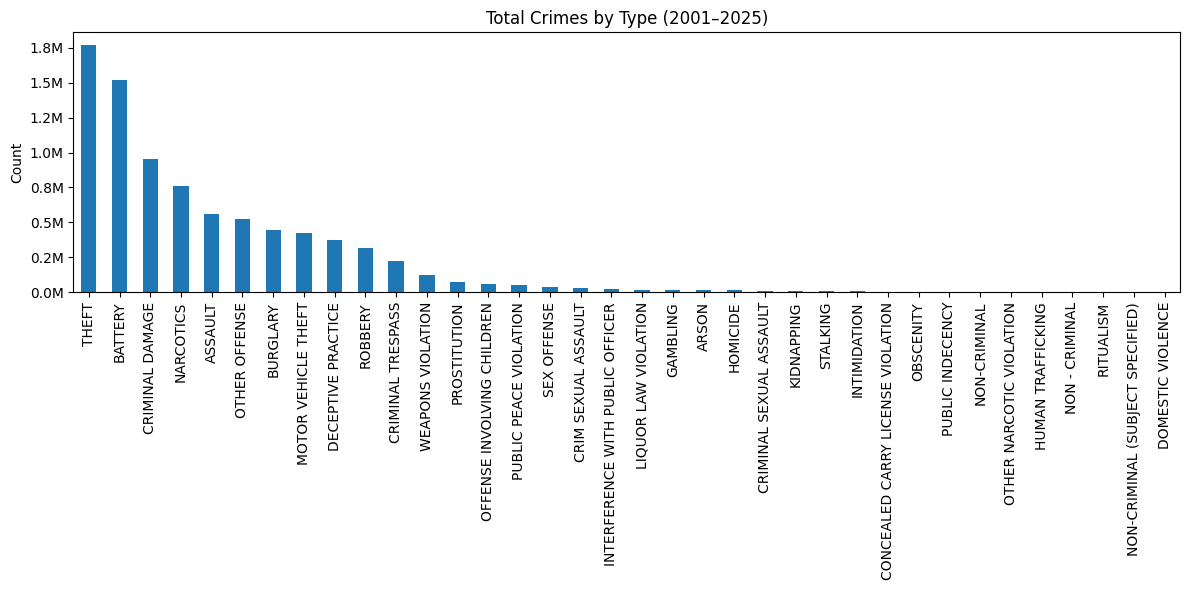

In [56]:
# Crime types
fig, ax = plt.subplots(figsize=(12,6))
crime_df.plot(kind='bar', legend=False, ax=ax)

ax.set_title("Total Crimes by Type (2001–2025)")
ax.set_ylabel("Count")

# Format y-axis to show in millions with 'M'
formatter = FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


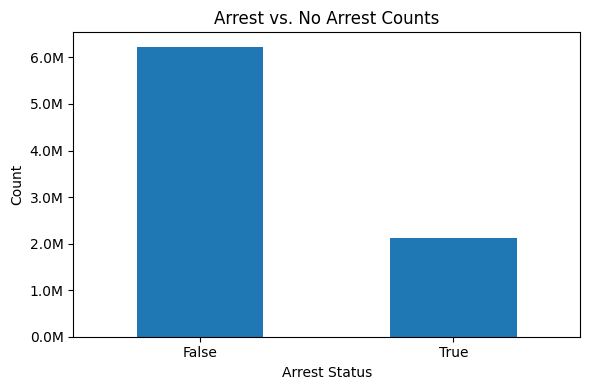

In [69]:
arrest_df = pd.DataFrame(
    list(arrest_counter.items()), 
    columns=['Arrest Status', 'Count']
).set_index('Arrest Status')

fig, ax = plt.subplots(figsize=(6,4))

arrest_df.plot(kind='bar', legend=False, ax=ax)

ax.set_title("Arrest vs. No Arrest Counts")
ax.set_ylabel("Count")
ax.set_xlabel("Arrest Status")

# Format y-axis in millions
formatter = FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M')
ax.yaxis.set_major_formatter(formatter)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


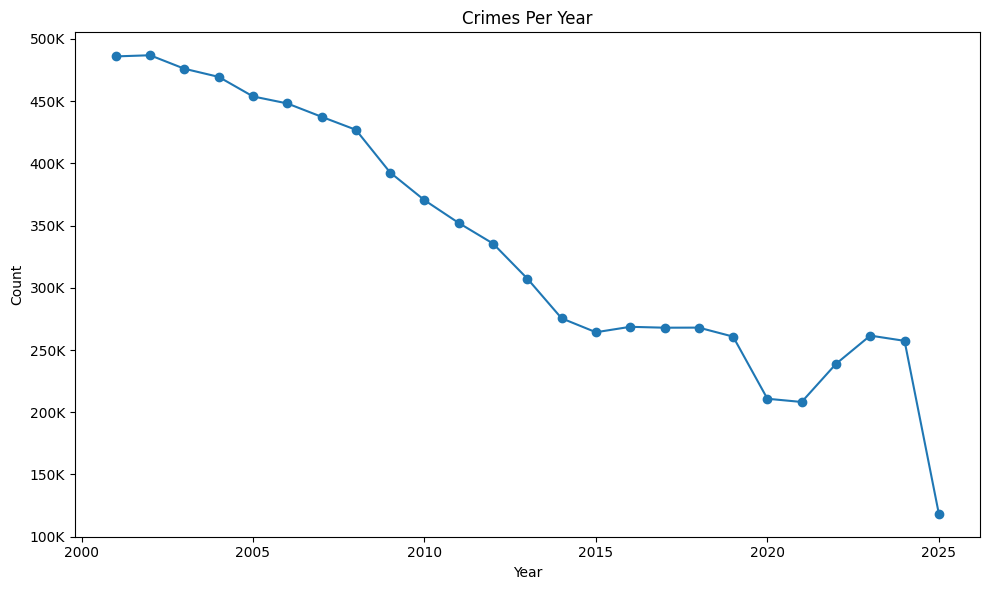

In [70]:
year_df = pd.DataFrame.from_dict(year_counter, orient='index', columns=['count']).sort_index()

fig, ax = plt.subplots(figsize=(10,6))

year_df.plot(kind='line', marker='o', legend=False, ax=ax)

ax.set_title("Crimes Per Year")
ax.set_ylabel("Count")
ax.set_xlabel("Year")

# Format y-axis in thousands
formatter_k = FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}K')
ax.yaxis.set_major_formatter(formatter_k)

plt.tight_layout()
plt.show()

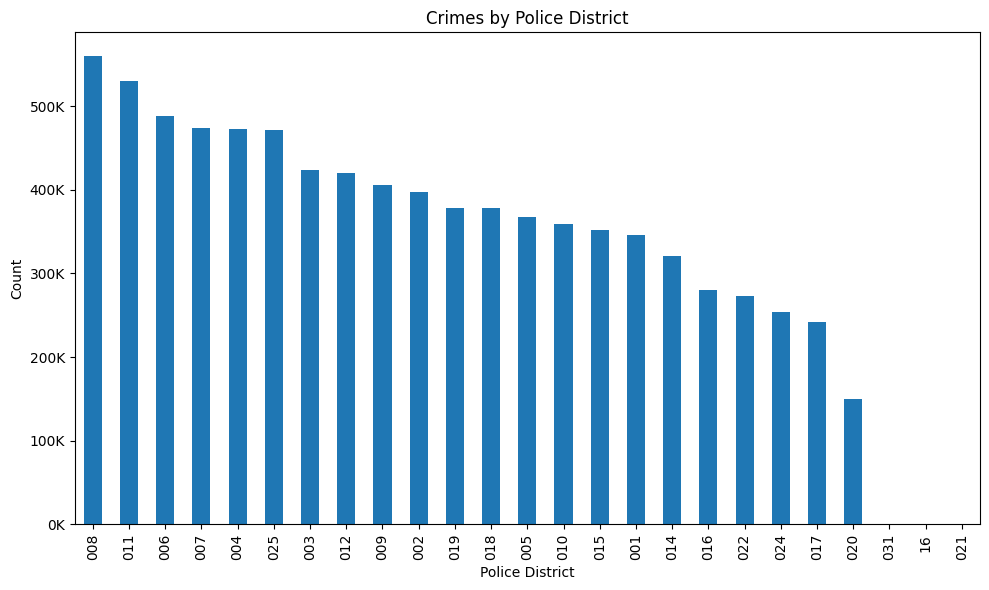

In [72]:
district_df = pd.DataFrame.from_dict(
    district_counter, orient='index', columns=['count']
).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(10,6))

district_df.plot(kind='bar', legend=False, ax=ax)

ax.set_title("Crimes by Police District")
ax.set_ylabel("Count")
ax.set_xlabel("Police District")

# Format y-axis in thousands
formatter_k = FuncFormatter(lambda x, pos: f'{x*1e-3:.0f}K')
ax.yaxis.set_major_formatter(formatter_k)

plt.tight_layout()
plt.show()


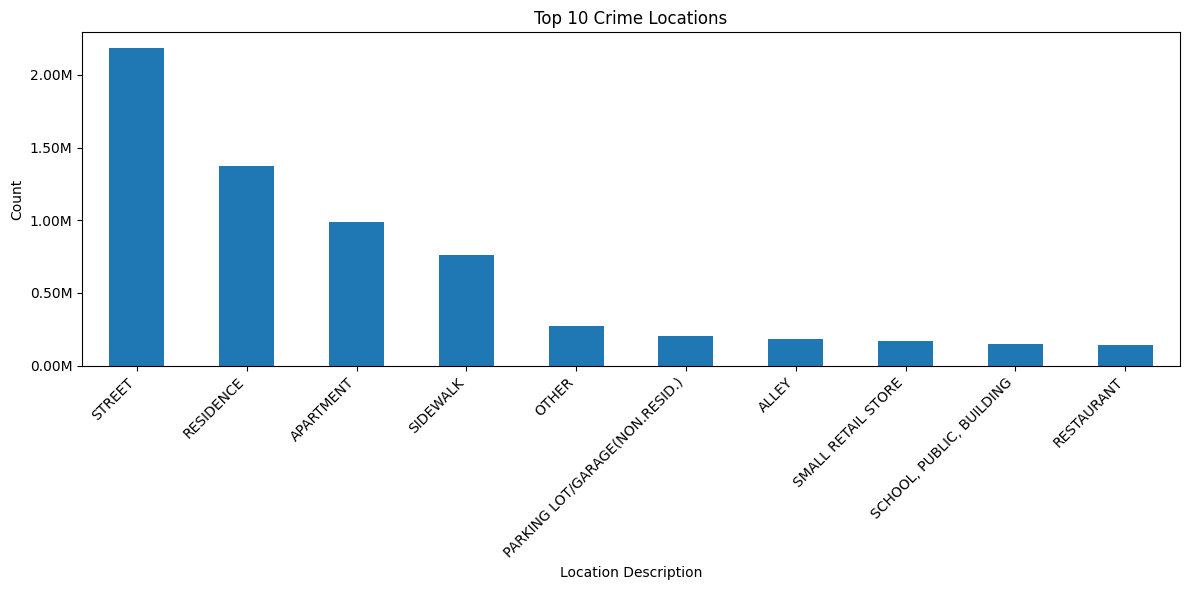

In [73]:
location_df = pd.DataFrame.from_dict(
    location_counter, orient='index', columns=['count']
).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))

location_df.head(10).plot(
    kind='bar', legend=False, ax=ax
)

ax.set_title("Top 10 Crime Locations")
ax.set_ylabel("Count")
ax.set_xlabel("Location Description")

# Format y-axis in millions
formatter_m = FuncFormatter(lambda x, pos: f'{x*1e-6:.2f}M')
ax.yaxis.set_major_formatter(formatter_m)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

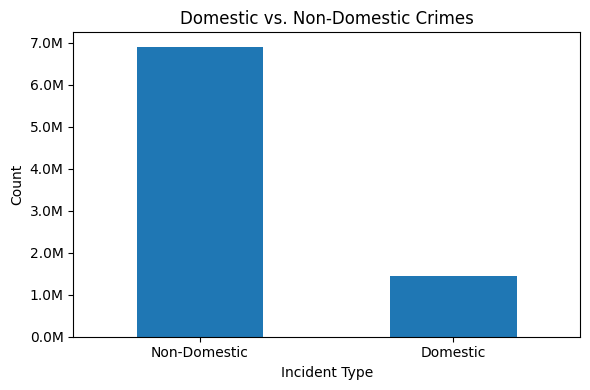

In [75]:
domestic_df = pd.DataFrame.from_dict(
    domestic_counter, orient='index', columns=['count']
).sort_values('count', ascending=False)

# Optional: map boolean to labels
domestic_df.index = domestic_df.index.map({True: 'Domestic', False: 'Non-Domestic'})

fig, ax = plt.subplots(figsize=(6,4))

domestic_df.plot(kind='bar', legend=False, ax=ax)

ax.set_title("Domestic vs. Non-Domestic Crimes")
ax.set_ylabel("Count")
ax.set_xlabel("Incident Type")

formatter_m = FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M')
ax.yaxis.set_major_formatter(formatter_m)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
